<a href="https://colab.research.google.com/github/nooyeat/project/blob/main/%EC%A3%BC%EC%8B%9D%EA%B0%90%EC%A0%95%EB%B6%84%EC%84%9D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 필요한 라이브러리 로드
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, GRU, BatchNormalization
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
import random
import numpy as np
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# 하이퍼파라미터 튜닝을 하기 위해 시드값 설정하여 결과를 고정
# 시드 설정 함수
def set_seed(seed=114):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

set_seed(114)

# nltk 라이브러리의 불용어 다운로드
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')

# 불용어 리스트 설정 (영어)
stop_words = set(stopwords.words('english'))

# 텍스트 전처리 함수 정의
def preprocess_text(text):
    # 소문자로 변환
    text = text.lower()
    # 특수 문자 제거
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # 불용어 제거
    words = word_tokenize(text)
    words = [word for word in words if word not in stop_words]
    # 하나의 문자열로 결합
    return ' '.join(words)

# 데이터 로드
data = pd.read_csv('stock_data.csv')

# 텍스트 데이터 전처리
texts = data.Text.astype(str).apply(preprocess_text).values
sentiments = data.Sentiment.values

# 레이블 인코딩
label_encoder = LabelEncoder() # LabelEncoder 객체 생성
labels = label_encoder.fit_transform(sentiments) # 데이터의 sentiment를 정수형 레이블로 변환 -1, 1 -> 0, 1

# 학습, 검증, 테스트 데이터셋 분리 (6:2:2)
X_train, X_temp, y_train, y_temp = train_test_split(texts, labels, test_size=0.4, random_state=24)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=24)

# 텍스트 데이터를 시퀀스로 변환
tokenizer = Tokenizer() # Tokenizer 객체 생성
tokenizer.fit_on_texts(X_train) # 학습 데이터의 텍스트를 기준으로 Tokenizer 단어 사전 생성

# 텍스트를 정수 시퀀스로 변환
X_train_seq = tokenizer.texts_to_sequences(X_train) # 학습 데이터
X_val_seq = tokenizer.texts_to_sequences(X_val) # 검증 데이터
X_test_seq = tokenizer.texts_to_sequences(X_test) # 테스트 데이터

# 학습을 위해 시퀀스의 길이를 동일하게 패딩
max_length = max(len(seq) for seq in X_train_seq) # 학습 데이터의 최대 시퀀스
X_train_padded = pad_sequences(X_train_seq, maxlen=max_length, padding='post')
X_val_padded = pad_sequences(X_val_seq, maxlen=max_length, padding='post')
X_test_padded = pad_sequences(X_test_seq, maxlen=max_length, padding='post')

# 모델 설계
model = Sequential([
    Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=128, input_length=max_length), # 임베딩 층
    Bidirectional(LSTM(16, return_sequences=False)), # 양방향 LSTM 층
    BatchNormalization(), # 배치 정규화
    Dropout(0.3), # 드롭아웃으로 과적합 방지
    Dense(16, activation='relu', kernel_regularizer=l2(0.01)), # L2 정규화가 적용된 fully connected layer
    BatchNormalization(), # 배치 정규화
    Dropout(0.3), # 드롭아웃 추가
    Dense(1, activation='sigmoid') # 출력층(이진 분류를 위한 sigmoid 활성화 함수 사용)
])
optimizer = Adam(learning_rate=0.0005) # Adam 최적화 알고리즘 사용(학습률: 0.0005)

# 모델 컴파일
# 손실함수: binary crossentropy loss, 평가지표: accuracy
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# 조기 종료 설정
# 검증 손실이 3번 연속으로 감소하지 않으면 학습 중단, 최적의 가중치를 복원한다
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# 모델 학습
history = model.fit(
    # 학습 데이터
    X_train_padded, y_train,
    # 검증 데이터
    validation_data=(X_val_padded, y_val),
    # 최대 20번의 에포크 동안 학습
    epochs=20,
    # 배치 크기 32
    batch_size=32,
    # 조기 종룍 콜백
    callbacks=[early_stopping]
)

# 모델 평가
# 테스트 데이터로 모델 평가
loss, accuracy = model.evaluate(X_test_padded, y_test)
print(f"테스트 데이터 정확도: {accuracy:.1f}")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


109/109 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.5573 - loss: 1.0328 - val_accuracy: 0.6598 - val_loss: 0.8510
Epoch 2/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.7472 - loss: 0.7097 - val_accuracy: 0.6779 - val_loss: 0.7859
Epoch 3/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.8596 - loss: 0.5133 - val_accuracy: 0.7219 - val_loss: 0.6942
Epoch 4/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9201 - loss: 0.3747 - val_accuracy: 0.7547 - val_loss: 0.6357
Epoch 5/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.9440 - loss: 0.2844 - val_accuracy: 0.6736 - val_loss: 0.7140
Epoch 6/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.9684 - loss: 0.2152 - val_accuracy: 0.6978 - val_loss: 0.7929
Epoch 7/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9809 - loss: 0.1698 - val_accuracy: 0.6865 - val_loss: 0.9220
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7851 - loss: 0.6098
테스트 데이터 정확도: 0.8


In [ ]:
print(model.summary())

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ (None, 22, 128)             │         903,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_2 (Bidirectional)      │ (None, 32)                  │          18,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 16)                  │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,767,205 (10.56 MB)

 Trainable params: 922,369 (3.52 MB)

 Non-trainable params: 96 (384.00 B)

 Optimizer params: 1,844,740 (7.04 MB)

None


In [ ]:
# 새로운 텍스트를 예측하기 위한 함수
def predict_sentiment(text, tokenizer, model, label_encoder, max_length):
    # 입력 텍스트를 전처리
    processed_text = preprocess_text(text)
    # 전처리된 텍스트 -> 정수 시퀀스로 변환
    sequence = tokenizer.texts_to_sequences([processed_text])
    # max_length로 패딩
    padded_sequence = pad_sequences(sequence, maxlen=max_length, padding='post')
    # 모델로 예측
    prediction = model.predict(padded_sequence)
    # 예측 확률을 0.5를 기준으로 레이블 변환
    sentiment_label = (prediction > 0.5).astype(int).item()
    # 레이블이 1일 경우 긍정(상승), 0일 경우 부정(하락)으로 출력
    if sentiment_label == 1:
        sentiment = "긍정(상승)"
    else:
        sentiment = "부정(하락)"
    return sentiment

In [ ]:
# 예제 입력 텍스트
new_text = "Too early to short into this move. Stock Market needs a few days to settle down "

# 감정 예측
predicted_sentiment = predict_sentiment(new_text, tokenizer, model, label_encoder, max_length)
print(new_text)
print(f"감정 예측: {predicted_sentiment}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step
Too early to short into this move. Stock Market needs a few days to settle down 
감정 예측: 부정(하락)


In [ ]:
# 예제 입력 텍스트
new_text = "AMZN holding up well - next buy point when clears this upper trend line on heavy volume"

# 감정 예측
predicted_sentiment = predict_sentiment(new_text, tokenizer, model, label_encoder, max_length)
print(new_text)
print(f"감정 예측: {predicted_sentiment}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
AMZN holding up well - next buy point when clears this upper trend line on heavy volume
감정 예측: 긍정(상승)


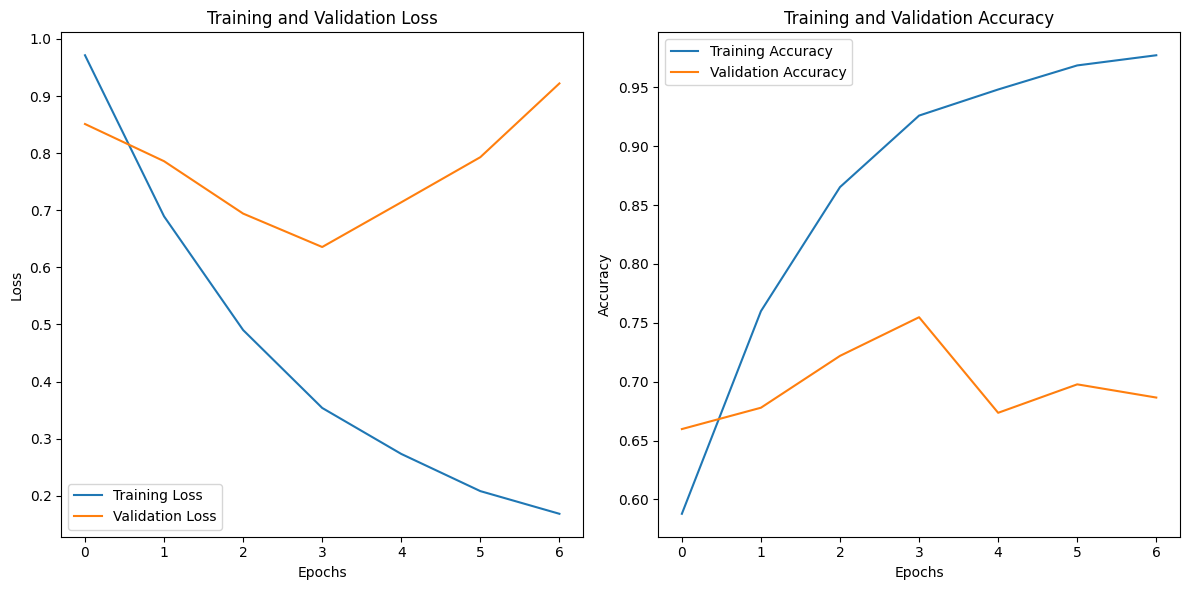

In [ ]:
# 훈련과 검증 데이터의 loss 시각화
plt.figure(figsize=(12, 6))

# Loss 그래프
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Accuracy 그래프
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.tight_layout()
plt.show()